In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import glob, os, json
import pandas as pd
from helper import *
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.offsetbox import AnchoredText

In [2]:
proj_root="/pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_performance/CB05CL_AE5_w_simpolSOA"

N_GAS_SPEC = 84
N_AERO_SPEC = 5
N_ENV_PARAMS = 3

In [3]:
dev_str = 'CUDA/trbdf-no_sacado'
dev_dir = os.path.join(proj_root, dev_str)
json_pattern = os.path.join(str(dev_dir),'wall_*.json')
gpu_list= glob.glob(json_pattern)

gpu = create_dataFrame_gpu(gpu_list)

Unable to read /pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_performance/CB05CL_AE5_w_simpolSOA/CUDA/trbdf-no_sacado/wall_times_nbatch_100_vecsize_4_teamThread_size_512_number_of_particles_1.json: Expected object or value
Unable to read /pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_performance/CB05CL_AE5_w_simpolSOA/CUDA/trbdf-no_sacado/wall_times_nbatch_100_vecsize_8_teamThread_size_64_number_of_particles_1.json: Expected object or value
Unable to read /pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_performance/CB05CL_AE5_w_simpolSOA/CUDA/trbdf-no_sacado/wall_times_nbatch_100_vecsize_30_teamThread_size_64_number_of_particles_100.json: Expected object or value
Unable to read /pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_performance/CB05CL_AE5_w_simpolSOA/CUDA/trbdf-no_sacado/wall_times_nbatch_100_vecsize_16_teamThread_size_256_number_of_particles_100.json: Expected object or value
Unable to read /pscratch/sd/s/samfred/TChem/TChem-atm/scripts/aerosol_pe

In [4]:
vector_sizes = [2, 4, 8, 16, 30]
team_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1023]
n_particles = [1, 10, 100, 1000]
values = np.zeros((len(n_particles), len(vector_sizes), len(team_sizes)))

n_samples = 100
for pidx, particles in enumerate(n_particles):
    for i, vector in enumerate(vector_sizes):
        for j, team in enumerate(team_sizes):
            _data = gpu[(gpu.vector_size == vector) & (gpu.team_size == team) & (gpu.nParticles == particles) & (gpu.nSamples == n_samples)]
            if _data.empty:
                values[pidx, i,j] = np.nan
            else:
                val = _data.loc[:,'walltime'][0]
                values[pidx, i,j] = val

/tmp/ipykernel_1155184/3099224886.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = _data.loc[:,'walltime'][0]


number of particles: 1
min: 0.0317, max: 0.1814, mean: 0.0548
Minimum: vector size 16, team size 16
Vector 30, Team 16 is within 5.60% of the fastest configuration

number of particles: 10
min: 0.0427, max: 0.3168, mean: 0.0878
Minimum: vector size 4, team size 64
Vector 30, Team 16 is within 12.30% of the fastest configuration

number of particles: 100
min: 1.6197, max: 44.5938, mean: 9.3479
Minimum: vector size 30, team size 16
Vector 30, Team 16 is within 0.00% of the fastest configuration

number of particles: 1000
min: nan, max: nan, mean: nan


/tmp/ipykernel_360976/403226475.py:8: RuntimeWarning: All-NaN slice encountered
  v_min = np.nanmin(values[pidx, :, :])
/tmp/ipykernel_360976/403226475.py:9: RuntimeWarning: All-NaN slice encountered
  v_max = np.nanmax(values[pidx, :, :])
/tmp/ipykernel_360976/403226475.py:10: RuntimeWarning: Mean of empty slice
  v_mean = np.nanmean(values[pidx, :, :])


ValueError: All-NaN slice encountered

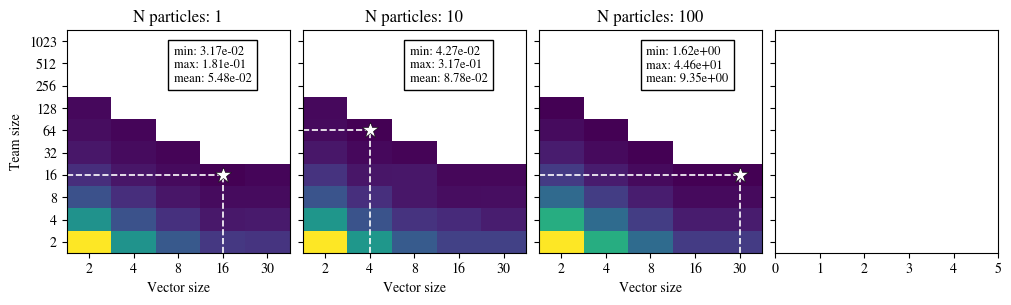

In [15]:
#norm = mpl.colors.LogNorm(vmin=1e-7, vmax=1e-4)
fig, axs = plt.subplots(1,4, figsize=(10, 4), sharey=True, layout='constrained',subplot_kw=dict(box_aspect=1))

#norm = mpl.colors.LogNorm(vmin=np.nanmin(values), vmax=np.nanmax(values))
for pidx, ax in enumerate(axs.flatten()):
    
    c = ax.pcolormesh(values[pidx, :, :].T, )#norm=norm)
    v_min = np.nanmin(values[pidx, :, :])
    v_max = np.nanmax(values[pidx, :, :])
    v_mean = np.nanmean(values[pidx, :, :])
    print(f"number of particles: {10**pidx}")
    print(f"min: {v_min:3.4f}, max: {v_max:3.4f}, mean: {v_mean:3.4f}")
    

    flat_index = np.nanargmin(values[pidx, :, :])
    v_idx_min, t_idx_min = np.unravel_index(flat_index, values[pidx, :, :].shape)

    v_min = vector_sizes[v_idx_min]
    t_min = team_sizes[t_idx_min]
    print(f"Minimum: vector size {v_min}, team size {t_min}")

    # vector size 30, team size 16 
    t_v30_t16 = values[pidx, 4, 3]
    t_min = values[pidx, v_idx_min, t_idx_min]
    re = 100*abs(t_v30_t16-t_min)/t_min
    print(f"Vector 30, Team 16 is within {re:3.2f}% of the fastest configuration\n")

    
    ax.plot([v_idx_min+0.5, v_idx_min+0.5], [0, t_idx_min+0.5], c='white', ls='--', lw=1.2)
    ax.plot([0, v_idx_min+0.5], [t_idx_min+0.5, t_idx_min+0.5], c='white', ls='--', lw=1.2)
    ax.plot(v_idx_min+0.5, t_idx_min+0.5, marker='*', c='white', markersize=12, markeredgecolor='k', markeredgewidth=.4)

    time_min = np.nanmin(values[pidx, :, :])
    time_max = np.nanmax(values[pidx, :, :])
    time_mean = np.nanmean(values[pidx, :, :])
    ax.text(2.4, 7.7, f"min: {time_min:3.2e}\nmax: {time_max:3.2e}\nmean: {time_mean:3.2e}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))

    #ax.annotate('x', c='r', xy=(v_idx_min+0.5, t_idx_min+0.5), xytext=(v_idx_min+0.5, t_idx_min+0.5), 
    #            horizontalalignment='center', verticalalignment='center')

    ax.set_xticks(np.arange(.5, len(vector_sizes), 1))
    ax.set_xticklabels(vector_sizes)
    ax.set_xlabel('Vector size')

    ax.set_yticks(np.arange(.5, len(team_sizes), 1))
    ax.set_yticklabels(team_sizes)
    if pidx == 0:
        ax.set_ylabel('Team size')

    ax.set_title(f'N particles: {n_particles[pidx]}')
    
    
    
cbar = fig.colorbar(c, ax=axs, orientation='horizontal', fraction=0.15, pad=0.1)
cbar.set_label('Wall time')

Minimum: vector size 30, team size 16


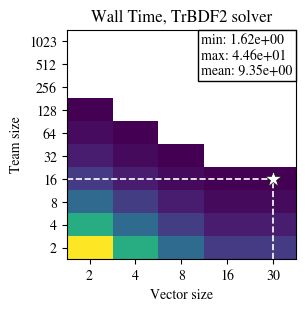

In [7]:
pidx = 2
#norm = mpl.colors.LogNorm(vmin=1e-7, vmax=1e-4)
fig, ax = plt.subplots(1,1, figsize=(3, 3), sharey=True, layout='constrained',subplot_kw=dict(box_aspect=1))

#norm = mpl.colors.LogNorm(vmin=np.nanmin(values[:, :]), vmax=np.nanmax(values[:, :]))

flat_index = np.nanargmin(values[pidx, :, :])
v_idx_min, t_idx_min = np.unravel_index(flat_index, values[pidx, :, :].shape)

v_min = vector_sizes[v_idx_min]
t_min = team_sizes[t_idx_min]
print(f"Minimum: vector size {v_min}, team size {t_min}")

ax.plot([v_idx_min+0.5, v_idx_min+0.5], [0, t_idx_min+0.5], c='white', ls='--', lw=1.2)
ax.plot([0, v_idx_min+0.5], [t_idx_min+0.5, t_idx_min+0.5], c='white', ls='--', lw=1.2)
ax.plot(v_idx_min+0.5, t_idx_min+0.5, marker='*', c='white', markersize=12, markeredgecolor='k', markeredgewidth=.4)

time_min = np.nanmin(values[pidx, :, :])
time_max = np.nanmax(values[pidx, :, :])
time_mean = np.nanmean(values[pidx, :, :])
#ax.text(3, 8, , fontsize=10,
#        bbox=dict(facecolor='white', edgecolor='black'))

txt = AnchoredText(f"min: {time_min:3.2e}\nmax: {time_max:3.2e}\nmean: {time_mean:3.2e}",
                    loc='upper right', prop=dict(size=10), frameon=True,
                    bbox_to_anchor=(1., 1.), borderpad=0, pad=0.25,
                    bbox_transform=ax.transAxes
                    )
ax.add_artist(txt)

c = ax.pcolormesh(values[pidx, :, :].T, )#norm=norm)

ax.set_xticks(np.arange(.5, len(vector_sizes), 1))
ax.set_xticklabels(vector_sizes)
ax.set_xlabel('Vector size')

ax.set_yticks(np.arange(.5, len(team_sizes), 1))
ax.set_yticklabels(team_sizes)
ax.set_ylabel('Team size')

#ax.set_title(f'N particles: {n_particles[pidx]}')
ax.set_title(f'Wall Time, TrBDF2 solver')

#cbar = fig.colorbar(c, ax=axs, orientation='horizontal', fraction=0.15, pad=0.1)
#cbar.set_label('Wall time')
plt.savefig("RHS-timings-trbdf.pdf",  bbox_inches="tight", format='pdf')